## Qibolab installation
To install Qibolab it is sufficient to uncomment the following line for bash users

In [1]:
%%bash
pip install qibolab[emulator]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qibolab import ConfigKinds, DcChannel, IqChannel, Platform, Qubit, Parameters, PulseSequence, Delay, Sweeper, Delay, AveragingMode, Parameter
from qibolab.instruments.emulator import (
    DriveEmulatorConfig,
    EmulatorController,
    FluxEmulatorConfig,
    HamiltonianConfig,
)

## Introduction to Qibolab
Qibolab is the Qibo module dedicated to deploying Qibo circuits on self-hosted quantum hardware.
In order to do so Qibolab provides abstractions to describe a Quantum Processing Units QPU as a `Platform`. Moreover, Qibolab introduces an API to run low-level experiments tailored to superconducting qubits based on `PulseSequence`.

To run a few experiments we are going to use a special platform based on `Qutip` which enables us to simulate a real QPU.
In the following line we will setup the `Platform`.

In [3]:
config = {
  "settings": {
    "nshots": 1024,
    "relaxation_time": 0
  },
  "configs": {
    "emulator/bounds": {
    "kind": "bounds",
    "waveforms": 1000000,
    "readout": 50,
    "instructions": 200
  },
  "hamiltonian":{
    "transmon_levels": 2,
    "single_qubit": {
      "0": {
        "frequency": 5e9,
        "sweetspot": 0.02,
        "anharmonicity": -200e6,
        "asymmetry": 0.0,
        "t1": {
          "0-1": 1000
        },
        "t2": {
          "0-1": 1900
        }
      }
    },
    "kind": "hamiltonian"
  },
    "0/drive": {
      "kind": "drive-emulator",
      "frequency": 5e9,
      "scale_factor": 0.1591549
    },
    "0/drive12": {
      "kind": "drive-emulator",
      "frequency": 4.8e9,
      "scale_factor": 0.1591549
    },
    "0/flux": {
        "kind": "flux-emulator",
        "offset": 0.02
      },
  "0/probe": {
    "kind": "iq",
    "frequency": 5200000000.0
  },
  "0/acquisition": {
    "kind": "acquisition",
    "delay": 0.0,
    "smearing": 0.0,
    "threshold": 0.0,
    "iq_angle": 0.0,
    "kernel": None
  }
  },
  "native_gates": {
    "single_qubit": {
      "0": {
        "RX": [
          [
            "0/drive",
            {
              "duration": 40,
              "amplitude": 0.1594,
              "envelope": {
                "kind": "gaussian",
                "rel_sigma": 0.2
              },
              "relative_phase": 0.0,
              "kind": "pulse"
            }
          ]
        ],
        "RX90": [
          [
            "0/drive",
            {
              "duration": 40,
              "amplitude": 0.07975,
              "envelope": {
                "kind": "gaussian",
                "rel_sigma": 0.2
              },
              "relative_phase": 0.0,
              "kind": "pulse"
            }
          ]
        ],
        "MZ": [
          [
            "0/acquisition",
            {
              "kind": "readout",
              "acquisition": {
                "kind": "acquisition",
                "duration": 100.0
              },
              "probe": {
                "duration": 100.0,
                "amplitude": 0.1,
                "envelope": {
                  "kind": "gaussian",
                  "rel_sigma": 0.2
                },
                "relative_phase": 0.0,
                "kind": "pulse"
              }
            }
          ]
        ],
        "CP": None
      }
    }
    }
  }

In [4]:
ConfigKinds.extend([HamiltonianConfig, DriveEmulatorConfig, FluxEmulatorConfig])

def create() -> Platform:
    """Create emulator platform with one qubit."""
    qubits = {}
    channels = {}

    for q in range(1):
        qubits[q] = qubit = Qubit.default(q)
        channels |= {
            qubit.drive: IqChannel(mixer=None, lo=None),
            qubit.flux: DcChannel(),
        }

    # register the instruments
    instruments = {
        "dummy": EmulatorController(address="0.0.0.0", channels=channels),
    }

    return Platform(
        name="emulator",
        parameters=Parameters(**config),
        instruments=instruments,
        qubits=qubits,
    )

platform = create()

[Qibo 0.2.16|INFO|2025-07-09 15:05:28]: Loading platform emulator


### Creating a sequence to measure the qubit
Now that we have setup a `Platform` object we are ready to start playing with `PulseSequence`.
We start by performing a simple sequence where we just measure the qubit.

In [5]:
natives = platform.natives.single_qubit[0] # native gates available for qubit 0
# intialize empty pulse sequence
seq = PulseSequence()
# let's append a measurement at the end
# NOTE: With + we append to the pulse sequence (starting from the initial time)
seq += natives.MZ()

results = platform.execute([seq], nshots=1000)

readout_id = seq.acquisitions[0][1].id
print(results[readout_id])

[Qibo 0.2.16|INFO|2025-07-09 15:05:28]: Minimal execution time: 0.0001


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

As expected we measured the qubit in the state $\ket{0}$ for every shot performed.
If we are interested in the average value, which will give an estimate of the probability of measuring $\ket{1}$, we can change the `AveragingMode` which defaults to `AveragingMode.SINGLESHOT` to `AveragingMode.CYCLIC`.
To better understand how Qibolab works let's inspect a `PulseSequence`.

In [6]:
results = platform.execute([seq], averaging_mode = AveragingMode.CYCLIC, nshots=1000)
readout_id = seq.acquisitions[0][1].id
print(results[readout_id])

[Qibo 0.2.16|INFO|2025-07-09 15:05:29]: Minimal execution time: 0.0001


0.0


In [7]:
for ch, pulse in seq:
    print("CHANNEL", ch)
    print("PULSE", pulse)

CHANNEL 0/acquisition
PULSE id_=UUID('9b56fcde-dc5e-49a9-846a-24899c5098f3') kind='readout' acquisition=Acquisition(id_=UUID('72a2b9dc-91a2-4f41-96ea-e8d6d8c7c107'), kind='acquisition', duration=100.0) probe=Pulse(id_=UUID('164b1a24-4020-4b96-bb9f-790c14bbf535'), kind='pulse', duration=100.0, amplitude=0.1, envelope=Gaussian(kind='gaussian', rel_sigma=0.2), relative_phase=0.0)


Every element in the sequence is a tuple containing the channel where the pulse is going to be played and the pulse itself.

### Creating a sequence to measure the qubit in the excited state
To bring the qubit to state $\ket{1}$ it is sufficient
to use the native `RX`.

In [8]:
natives = platform.natives.single_qubit[0]
seq = PulseSequence()

# first we append the RX
seq += natives.RX()
# next we play the MZ pulse
seq |= natives.MZ()

results = platform.execute([seq], nshots=1000)

readout_id = seq.acquisitions[0][1].id
print(results[readout_id])

[Qibo 0.2.16|INFO|2025-07-09 15:05:30]: Minimal execution time: 0.00014000000000000001


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 

### Observe decoherence by adding a delay before the measurement

We see that sometimes we are measuring $\ket{0}$ because in the simulation we include dissipative effects.
In fact, we can push the measurement even later using a `Delay`. The delay needs to be added on the `Acquisition` channel.

In [9]:
natives = platform.natives.single_qubit[0]

seq = PulseSequence()

# retrieve acquisition channel
acquisition = platform.qubits[0].acquisition

# first we append the RX
seq += natives.RX()

seq.append((acquisition, Delay(duration=2000)))
seq += natives.MZ()

results = platform.execute([seq], nshots=1000)

readout_id = seq.acquisitions[0][1].id
print(results[readout_id])

[Qibo 0.2.16|INFO|2025-07-09 15:05:31]: Minimal execution time: 0.0021000000000000003


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1
 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 

As we can see above by putting a delay of around 2000 ns the qubit is measured mostly at $\ket{0}$ even if we put it in state $\ket{1}$ at the beginning of the sequence.

### Using sweepers in Qibolab: T1 experiment
The `execute` method in Qibolab supports also the possibility to perform a "sweep" using `Sweepers`. What is a "sweep"? Some instruments provide specific functionalities to repeat a measurement while modifying some parameters which can belong to a pulse or to the configuration of the instrument itself. In the case of a spectroscopic measurement we are usually changing the frequency on the channel where we are playing the pulse.

Using `Sweeper`s we can use `Qibolab` to code easily characterization experiments. For example for measuring the relaxation $T_1$ we need a single sweeper.

In [10]:
natives = platform.natives.single_qubit[0]

seq = PulseSequence()

# retrieve acquisition channel
acquisition = platform.qubits[0].acquisition

seq += natives.RX()
delay = Delay(duration=2000)
seq.append((acquisition, delay))
seq += natives.MZ()


# introduce sweeper
delay_range = np.arange(100,3000,100)
sweeper = Sweeper(
    parameter = Parameter.duration,
    pulses = [delay],
    values=delay_range
)

results = platform.execute([seq], [[sweeper]], nshots=2000, averaging_mode=AveragingMode.CYCLIC)
readout_id = seq.acquisitions[0][1].id
p1s = results[readout_id]

[Qibo 0.2.16|INFO|2025-07-09 15:05:33]: Minimal execution time: 0.12180000000000002


We can now plot the results and we should observe an exponential decay:

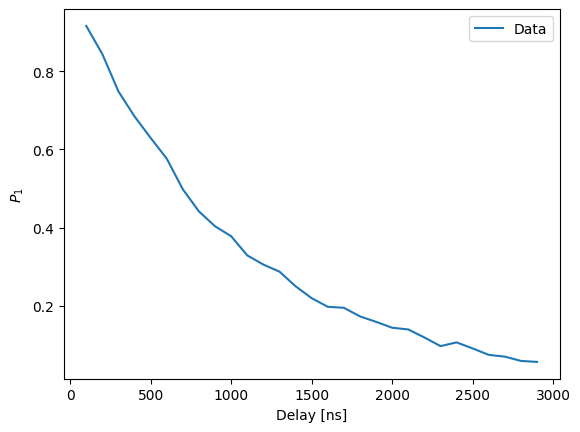

In [11]:
def plot(x, y, xlabel="Data", ylabel=r"$P_1$"):
    plt.plot(x, y, label=xlabel)
    plt.xlabel("Delay [ns]")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot(x=delay_range, y=p1s)

By performing a simple exponential fit we can compute the relaxation time $T_1$.

In [12]:
def exp_decay(x, *params):
    return params[0] - params[1]*np.exp(-x/params[2])
    
def fit_exp(x, y):
    popt, pcov = curve_fit(
        exp_decay,
        delay_range,
        p1s,
        p0 = [ 0.5, 0.5, 1000]
    )
    return popt

popt = fit_exp(x=delay_range, y=p1s)



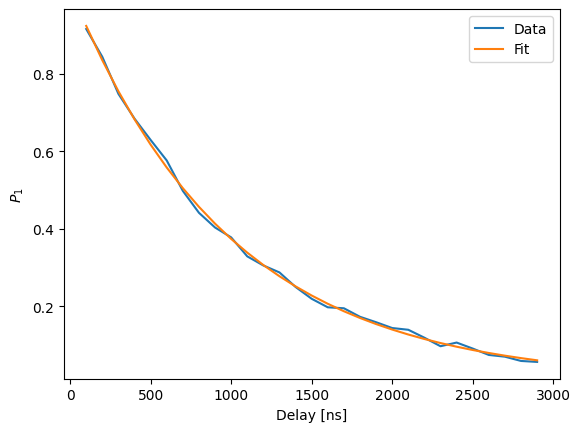

In [13]:
def plot_with_fit(x, y, xlabel="Data", ylabel=r"$P_1$", fun=exp_decay, popt=popt):
    plt.plot(x, y, label=xlabel)
    plt.plot(x, fun(x, *popt), label="Fit")
    plt.xlabel("Delay [ns]")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_with_fit(delay_range, p1s, fun=exp_decay, popt=popt)

In [14]:
print(f"The estimated T1 is {np.round(popt[2])}")
print(f"The simulation value used for T1 is {platform.config("hamiltonian").single_qubit[0].t1[0,1]}")

The estimated T1 is 982.0
The simulation value used for T1 is 1000.0


### Using sweepers in Qibolab: T2 experiment
In a similar fashion we can write an experiment to measure $T_2$, the coherence time. First, we move the qubit to the equator of the Bloch sphere using a `RX90` pulse, then we wait for a variable time $\tau$, then we apply again `RX90` and we measure. In the absence of decoherence we should be measure the qubit in state $\ket{1}.$ However, in reality the qubit precesses around the $z$ axis causing us to measure the qubit in a state which is a superposition of $\ket{0}$ and $\ket{1}$. 

In [15]:
natives = platform.natives.single_qubit[0]

seq = PulseSequence()

# we need to retrieve both the acquisition and the drive channels
acquisition = platform.qubits[0].acquisition
drive = platform.qubits[0].drive
delays = 2* [Delay(duration=2000)]
seq += natives.RX90()
seq.append((acquisition, Delay(duration=natives.RX90().duration)))
seq.append((drive, delays[0]))
seq.append((acquisition, delays[1]))
seq += natives.RX90()
seq.append((acquisition, Delay(duration=natives.RX90().duration)))
seq += natives.MZ()

# introduce sweeper
delay_range = np.arange(100,3000,100)
sweeper = Sweeper(
    parameter = Parameter.duration,
    pulses = delays,
    values=delay_range
)

results = platform.execute([seq], [[sweeper]], nshots=2000, averaging_mode=AveragingMode.CYCLIC)
readout_id = seq.acquisitions[0][1].id
p1s = results[readout_id]

[Qibo 0.2.16|INFO|2025-07-09 15:05:49]: Minimal execution time: 0.12644


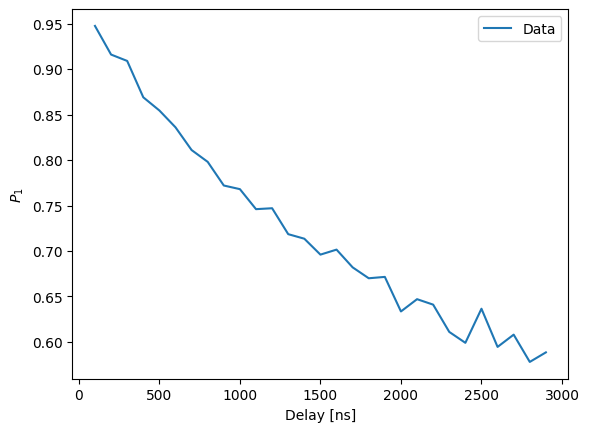

In [16]:
plot(x=delay_range, y=p1s)

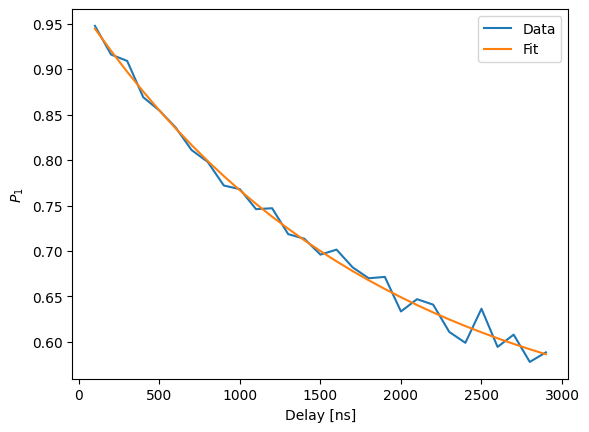

In [17]:
popt = fit_exp(delay_range, p1s)
plot_with_fit(delay_range, p1s, fun=exp_decay, popt=popt)

In [18]:
print(f"The estimated T2 is {np.round(popt[2])}")
print(f"The simulation value used for T2 is {platform.config("hamiltonian").single_qubit[0].t2[0,1]}")

The estimated T2 is 1823.0
The simulation value used for T2 is 1900.0


### Using sweepers in Qibolab: T2 echo

This experiment is similar to a Ramsey experiment, with the difference that between the two  pulses we apply a  pulse. Such  pulse is applied exactly at  where  is the waiting time between the two  pulses. By applying this extra pulse we can mitigate the qubit dephasing since any phase accumulated in first half of the sequence will be reversed in the second half. This is also why usually through this experiment we can get higher values of $T_2$ https://en.wikipedia.org/wiki/Spin_echo#/media/File:HahnEcho_GWM.gif


In [19]:
natives = platform.natives.single_qubit[0]

seq = PulseSequence()

# we need to retrieve both the acquisition and the drive channels
acquisition = platform.qubits[0].acquisition
drive = platform.qubits[0].drive
delays = 4* [Delay(duration=2000)]
seq += natives.RX90()
seq.append((acquisition, Delay(duration=natives.RX90().duration)))
seq.append((drive, delays[0]))
seq.append((acquisition, delays[1]))
seq += natives.RX()
seq.append((acquisition, Delay(duration=natives.RX().duration)))
seq.append((drive, delays[2]))
seq.append((acquisition, delays[3]))
seq += natives.RX90()
seq.append((acquisition, Delay(duration=natives.RX90().duration)))
seq += natives.MZ()

# introduce sweeper
delay_range = np.arange(100,3000,100)
sweeper = Sweeper(
    parameter = Parameter.duration,
    pulses = delays,
    values=delay_range / 2
)

results = platform.execute([seq], [[sweeper]], nshots=2000, averaging_mode=AveragingMode.CYCLIC)
readout_id = seq.acquisitions[0][1].id
p0s = 1 - results[readout_id]

[Qibo 0.2.16|INFO|2025-07-09 15:06:15]: Minimal execution time: 0.24476000000000003


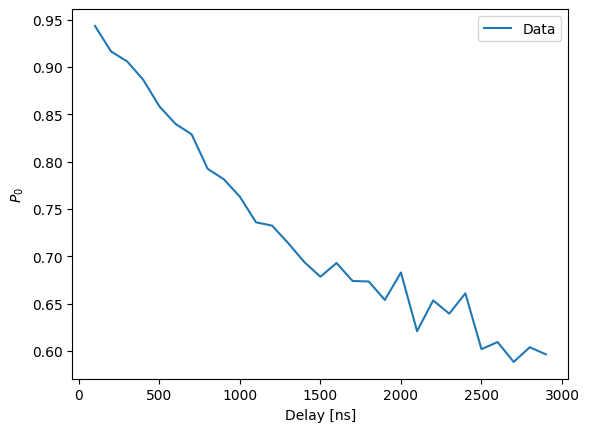

In [20]:
plot(delay_range, p0s, ylabel=r"$P_0$")

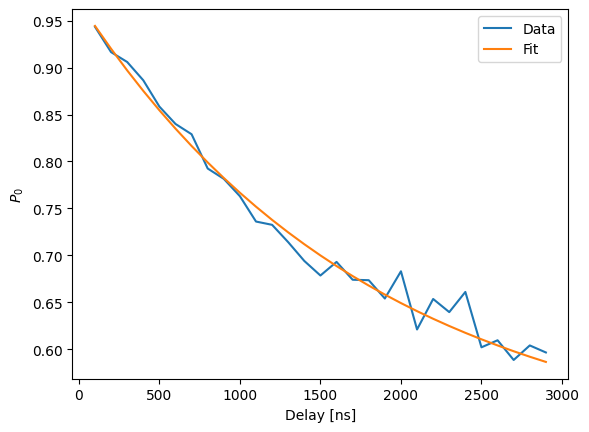

In [21]:
popt = fit_exp(x=delay_range, y=p0s)
plot_with_fit(x=delay_range, y=p0s, ylabel=r"$P_0$", popt=popt)

In [22]:
print(f"The estimated T2 echo is {np.round(popt[2])}")
print(f"The simulation value used for T2 echo is {platform.config("hamiltonian").single_qubit[0].t2[0,1]}")

The estimated T2 echo is 1823.0
The simulation value used for T2 echo is 1900.0
